In [1]:
import sys

import matplotlib.pyplot as plt
import torch

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src
from src.datasets.coco_eft import COCO_EFT
from src.datasets.datasets_common import UNNORMALIZE
from src.datasets.threedpw import ThreeDPW
from src.functional import smpl
from src.utils import img_utils, vis_utils

# COCO EFT tests

In [3]:
dset_coco = COCO_EFT(is_train=False) # if is_train=True, 3D transformation must be applied to original 3D points
batch_size = 5
dl = torch.utils.data.DataLoader(dset_coco, batch_size=batch_size, shuffle=False)
for x in dl:
    break

In [4]:
smpl_model = smpl.get_smpl_model("h36m")
faces = smpl_model.faces.astype(int)

In [5]:
img = UNNORMALIZE(x["img"])
shape_gt = x["smpl_shape"]
pose_gt = x["smpl_pose"]
cam_gt = x["parm_cam"]

gt_out = smpl_model(betas=shape_gt, body_pose=pose_gt[:, 3:], global_orient=pose_gt[:, :3], pose2rot=True)
verts_gt = gt_out.vertices
joints_gt = gt_out.joints

scale, trans = cam_gt[:, 0], cam_gt[:, 1:]

boxScale_o2n, bboxTopLeft, orig_shape, crop_shape = (
    x["bboxInfoScale"],
    x["bboxInfoTopLeft"],
    x["orig_shape"],
    x["crop_shape"],
)

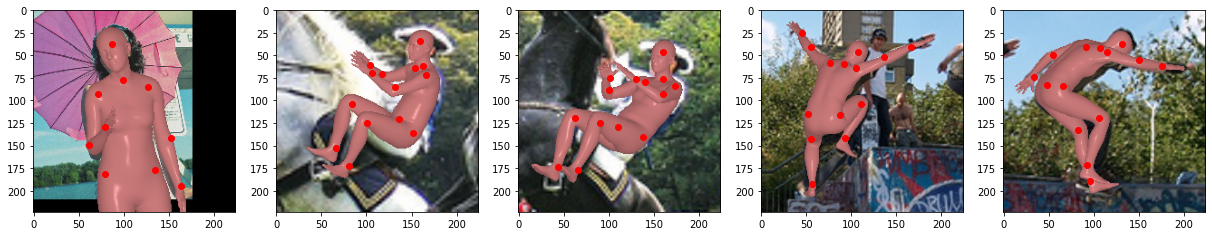

In [6]:
bbox_verts = img_utils.convert_norm_points_to_bbox(
    verts_gt.cpu(),
    scale,
    trans,
    crop_shape,
)

bbox_joints = img_utils.convert_norm_points_to_bbox(
    joints_gt.cpu(),
    scale,
    trans,
    crop_shape,
)

fig, ax = plt.subplots(1, batch_size, figsize=(21, 7))
for i in range(bbox_verts.size(0)):
    verts = bbox_verts[i].cpu().numpy()
    img_ = img[i].permute(1, 2, 0).numpy()
    blend_img = vis_utils.render_mesh_onto_image(img_, verts, faces)
    ax[i].scatter(bbox_joints[i,:,0], bbox_joints[i,:,1], c="red")
    ax[i].imshow(blend_img)

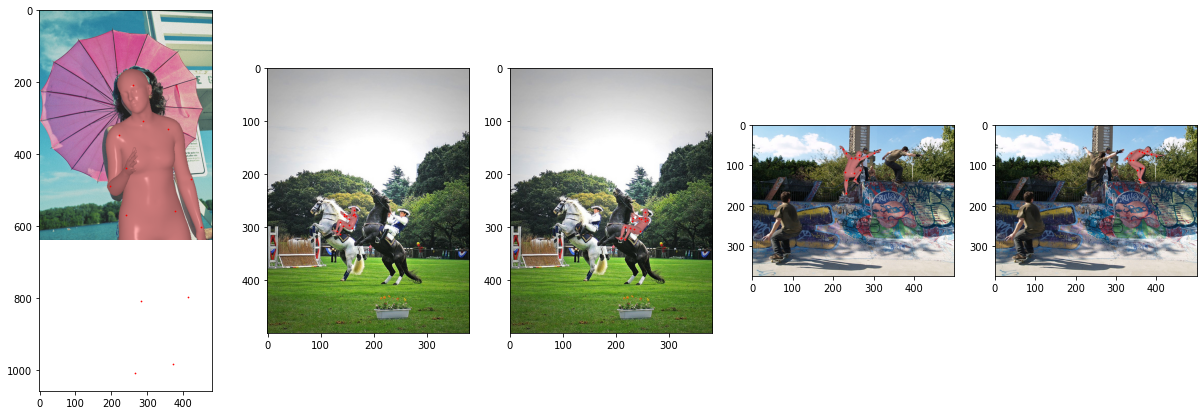

In [7]:
img_verts = img_utils.convert_smpl_vertices_to_image_coord(
    verts_gt.cpu(),
    scale,
    trans,
    boxScale_o2n,
    bboxTopLeft,
    orig_shape,
    crop_shape,
)

img_joints = img_utils.convert_smpl_vertices_to_image_coord(
    joints_gt.cpu(),
    scale,
    trans,
    boxScale_o2n,
    bboxTopLeft,
    orig_shape,
    crop_shape,
)

fig, ax = plt.subplots(1, batch_size, figsize=(21, 7))
for i in range(img_verts.size(0)):
    verts = img_verts[i].cpu().numpy()
    img_original = dset_coco.get_img(x["imgName"][i])
    blend_img = vis_utils.render_mesh_onto_image(img_original, verts, faces)
    ax[i].imshow(blend_img)
    ax[i].scatter(img_joints[i,:,0], img_joints[i,:,1], c="red", s=0.5)

# 3DPW tests

In [8]:
dset = ThreeDPW(set="test", seqlen=100, debug=True)

print(len(dset))
x = dset[0]
print(x.keys())
x["video"].shape

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 328
328
dict_keys(['features', 'theta', 'kp_2d', 'kp_3d', 'w_smpl', 'w_3d', 'instance_id', 'video'])


torch.Size([100, 3, 224, 224])

In [9]:
from src.functional import smpl
smpl_model = smpl.get_smpl_model("h36m")

In [10]:
import cv2
seq_name = "downtown_runForBus_01"
seq_path = f"/cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_original/sequenceFiles/test/{seq_name}.pkl"


dataset_path = "/cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_original"
import pickle as pkl
data = pkl.load(open(seq_path, 'rb'), encoding='latin1')
print(data.keys())

import os

dict_keys(['trans_60Hz', 'cam_intrinsics', 'poses', 'img_frame_ids', 'betas_clothed', 'sequence', 'v_template_clothed', 'jointPositions', 'poses_60Hz', 'betas', 'cam_poses', 'campose_valid', 'genders', 'trans', 'poses2d', 'texture_maps'])


In [11]:
# found a solution in
# https://github.com/akashsengupta1997/HierarchicalProbabilistic3DHuman/blob/main/data/pw3d_preprocess.py
person_num = 0

img_arr, j2d_arr, verts_arr = [], [], []
frames = [0, 25, 50, 75, 99]
for person_num in range(2):
    for frame_num in frames:
        image_file = os.path.join(dataset_path, 'imageFiles', seq_name, 'image_{}.jpg'.format(str(frame_num).zfill(5)))
        image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        img_arr.append(image)

        j2d = data["poses2d"][person_num].transpose(0,2,1)[frame_num]
        j2d_arr.append(j2d)

        cam_extrinsics = data["cam_poses"]
        shape = data["betas"][person_num][:10]
        pose = data["poses"][person_num][frame_num]
        cam_R = cam_extrinsics[frame_num][:3, :3]
        cam_t = cam_extrinsics[frame_num][:3, 3]
        frame_trans = data["trans"][person_num][frame_num]
        cam_K = data["cam_intrinsics"]

        device = "cpu"
        pose = torch.from_numpy(pose[None, :]).float().to(device)
        shape = torch.from_numpy(shape[None, :]).float().to(device)
        cam_t = torch.from_numpy(cam_t[None, :]).float().to(device)
        cam_R = torch.from_numpy(cam_R[None, :, :]).float().to(device)
        frame_trans = torch.from_numpy(frame_trans[None, :]).float().to(device)
        cam_K = torch.from_numpy(cam_K[None, :]).float().to(device)

        smpl_out = smpl_model(body_pose=pose[:, 3:], global_orient=pose[:, :3], betas=shape, transl=frame_trans)
        vertices = smpl_out.vertices
        verts = img_utils.perspective_projection(vertices, cam_R, cam_t, cam_K=cam_K)[0]
        verts_arr.append(verts)

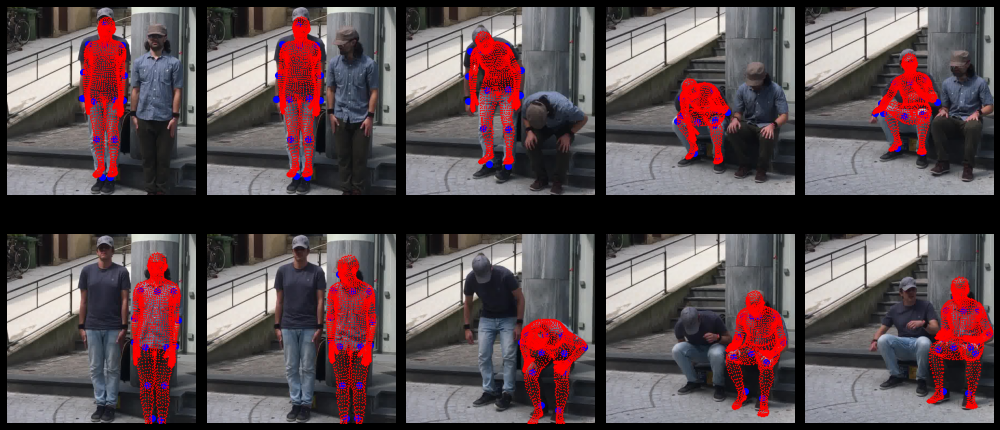

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(14, 7))

for axis, img, j2d, verts in zip(ax.flatten(), img_arr, j2d_arr, verts_arr):
    axis.imshow(img)
    mask = j2d[:, 2] > 0.3
    axis.scatter(j2d[mask][:, 0], j2d[mask][:, 1], c="blue")
    axis.scatter(verts[:, 0], verts[:, 1], c="red", s=0.1)
    axis.set_xlim(500, 1200)
    axis.set_ylim(900, 200)
    axis.set_axis_off()

fig.tight_layout()
fig.patch.set_facecolor("black")

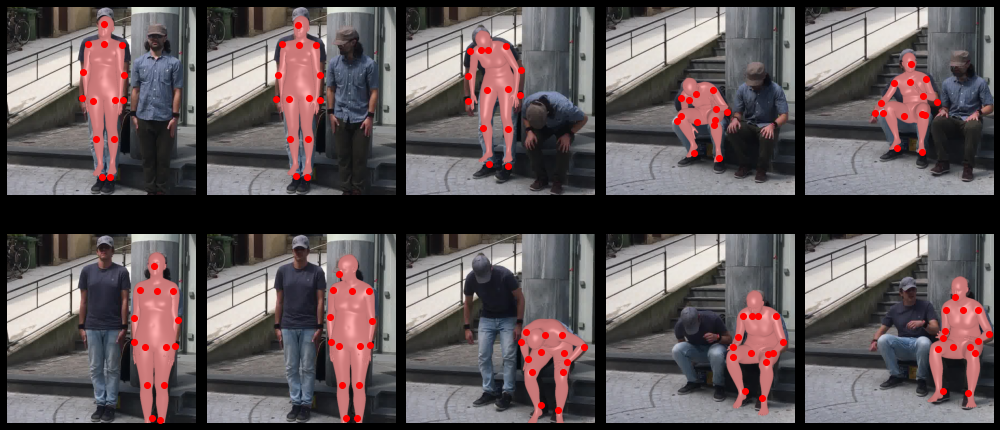

In [13]:
device = "cuda:3"

fig, ax = plt.subplots(2, 5, figsize=(14, 7))
for i, axis in enumerate(ax.flatten()):
    img = img_arr[i]
    verts = verts_arr[i].numpy().copy()

    #########
    ######
                    # is there a better solution? Why is it different from COCO EFT's?
    verts[:, 2] *= 100
    ###
    ######
    #########

    blend_img = vis_utils.render_mesh_onto_image(img, verts, faces, device=device)
    axis.imshow(blend_img)

    j2d = j2d_arr[i]
    mask = j2d[:, 2] > 0.3
    axis.scatter(j2d[mask][:, 0], j2d[mask][:, 1], c="red")
    axis.set_xlim(500, 1200)
    axis.set_ylim(900, 200)
    axis.set_axis_off()

fig.tight_layout()
fig.patch.set_facecolor("black")

In [14]:
### load original images from 3dpw
# from src.utils.img_utils_datasets_3d import convert_cvimg_to_tensor
# index = 0
# ###
# start_index, end_index = dset.vid_indices[index]
# vid_name = dset.db["vid_name"][start_index]
# vid_name = "_".join(vid_name.split("_")[:-1])
# f = os.path.join(dset.folder, "imageFiles", vid_name)
# video_file_list = [os.path.join(f, x) for x in sorted(os.listdir(f)) if x.endswith(".jpg")]
# frame_idxs = dset.db["frame_id"][start_index : end_index + 1]
# video = [video_file_list[i] for i in frame_idxs]
# video = [pathmgr.get_local_path(frame) for frame in video]
# video = [cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB) for image in video]
# video = torch.cat([convert_cvimg_to_tensor(image)[None] for image in video], dim=0)